<a href="https://colab.research.google.com/github/henryspg/DS-Unit-2-Applied-Modeling/blob/master/Airbnb_SF_aug_02_published.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Build Week - unit-2,*   dated: 07/31/20

---

#Airbnb San Francosco Price Prediction


**Intro**  
This project is a part of my data science projects that will show a step by step explanation on the implementation of Linear model with Sci-kit Learn and XGBoost.
In a regression problem, the goal is to predict a continuous target variable using mathematical functions. Linear models are linear relationship between the input features and the continuous target variable.  
I will be using the SF Airbnb Prices dataset and the data about SF neighbourhood median income and average house value. The goal is to predict the prices based on the features in the dataset  
The dataset about the listing is downloaded from:  
https://public.opendatasoft.com/explore/dataset/airbnb-listings/table/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&refine.city=San+Francisco   
and the dataset about SF neighborhood is copied from:  
https://www.homesnacks.net/best-neighborhoods-in-san-francisco-ca-128183/  
Both datasets are combined into a single csv file, named: Abnb.csv  

For XGBoost info:  
 https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

difference with next version: test_size=0.25

In [325]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [326]:
import pandas as pd
import numpy as np

In [327]:
abnb = pd.read_csv('Abnb_nbr.csv')

abnb.shape

(8680, 92)

In [328]:
# abnb.info()

In [329]:
# abnb['Neighbourhood Cleansed'].value_counts().sort_index()

In [330]:
# combine.nunique().sort_values()
# abnb.select_dtypes(exclude='number').nunique().sort_values()

In [331]:
# abnb.select_dtypes(include='number').nunique().sort_values()

In [332]:
# abnb.info()

In [333]:
abnb.isnull().sum()

ID               0
Listing Url      0
Scrape ID        0
Last Scraped     0
Name             0
                ..
Geolocation      0
Features         2
Population       0
Home_Value       0
Median_Income    0
Length: 92, dtype: int64

In [334]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    # Customise columns: Replace white space with underscore
    X.columns = X.columns.str.replace(' ', '_')  

    # Extract any 'good' Nulls value before they're removed.

    # 1. For string: Replace the nulls with 'not_listed', and impute missing values later. !!!
    cols_NaNs1 = ['Amenities', 'Features', 'Host_Response_Time']
    for col in cols_NaNs1:
        X[col] = X[col].fillna('not_listed')


    # 2. For numbers: Replace the nulls with 0 (fillna(0)), and impute missing values later. !!!
    cols_NaNs2 = ['Security_Deposit', 'Cleaning_Fee', 'Reviews_per_Month' ]
    for col in cols_NaNs2:
        X[col] = X[col].fillna(0)


    # Fillna for other columns with most frquent values. Definitely with 1 (one)
    cols3 = ['Bedrooms', 'Beds', 'Bathrooms']
    for col in cols3:
        X[col] = X[col].fillna(X[col].mode()[0])


    # Drop duplicates
    X = X.drop(columns=['Neighbourhood', 'Neighbourhood_Group_Cleansed'], axis=1)


    # Edit some string on Zipcode
    X['Zipcode'] = X['Zipcode'].str.replace('-1273', '' ).str.replace(' 94158', '').astype(str)
    X['Zipcode'] = X['Zipcode'].str.replace('94401', '94114').astype(str)

    # return the wrangled dataframe
    return X

abnb = wrangle(abnb)

In [335]:
# Rename dataframe from now on.

df = abnb.rename(columns={'Neighbourhood_Cleansed': 'Neighbourhood'})
df.shape

(8680, 90)

In [336]:
# df.info()

In [337]:
# Feature Engineering based on column 'Amenities'
# Does the unit provide TV, Internet, Breakfast, Kitchen, Air conditioning, Heating, Washer, Dryer

def hasAmenity(amenity):
  def hasItem(x):
    # print(x)
    if amenity in x:
      return 1
    else:
      return 0
  return hasItem


In [338]:
df['FreeParking'] = df['Amenities'].apply(hasAmenity("Free parking"))
df['TV'] = df['Amenities'].apply(hasAmenity("TV"))
df['Internet'] = df['Amenities'].apply(hasAmenity("Internet"))
df['Breakfast'] = df['Amenities'].apply(hasAmenity("Breakfast"))
df['Kitchen'] = df['Amenities'].apply(hasAmenity("Kitchen"))
df['Heating'] = df['Amenities'].apply(hasAmenity("Heating"))
df['Washer'] = df['Amenities'].apply(hasAmenity("Washer"))
df['Gym'] = df['Amenities'].apply(hasAmenity("Gym"))
df['Essentials'] = df['Amenities'].apply(hasAmenity("Essentials"))
df['AirCon'] = df['Amenities'].apply(hasAmenity("Air conditioning"))
df['NonSmoking'] = df['Amenities'].apply(hasAmenity("No smoking"))
df['Pool'] = df['Amenities'].apply(hasAmenity("Pool"))


In [339]:
df.head(3)

,ID,Listing_Url,Scrape_ID,Last_Scraped,Name,Summary,Space,Description,Experiences_Offered,Neighborhood_Overview,Notes,Transit,Access,Interaction,House_Rules,Thumbnail_Url,Medium_Url,Picture_Url,XL_Picture_Url,Host_ID,Host_URL,Host_Name,Host_Since,Host_Location,Host_About,Host_Response_Time,Host_Response_Rate,Host_Acceptance_Rate,Host_Thumbnail_Url,Host_Picture_Url,Host_Neighbourhood,Host_Listings_Count,Host_Total_Listings_Count,Host_Verifications,Street,Neighbourhood,City,State,Zipcode,Market,...,Maximum_Nights,Calendar_Updated,Has_Availability,Availability_30,Availability_60,Availability_90,Availability_365,Calendar_last_Scraped,Number_of_Reviews,First_Review,Last_Review,Review_Scores_Rating,Review_Scores_Accuracy,Review_Scores_Cleanliness,Review_Scores_Checkin,Review_Scores_Communication,Review_Scores_Location,Review_Scores_Value,License,Jurisdiction_Names,Cancellation_Policy,Calculated_host_listings_count,Reviews_per_Month,Geolocation,Features,Population,Home_Value,Median_Income,FreeParking,TV,Internet,Breakfast,Kitchen,Heating,Washer,Gym,Essentials,AirCon,NonSmoking,Pool
0,16603222,https://www.airbnb.com/rooms/16603222,2.020000e+13,4/2/2017,2 Bd+loft bed in HOT Victorian Mission district,Grand Victorian home in the heart of SF Missio...,Welcome to the Heart of San Francisco's Missio...,Grand Victorian home in the heart of SF Missio...,none,Follow this link to see 5 star reviews of my h...,NaN,2 blocks away from 24th and Mission Bart--it d...,No access to the backyard. Except for emergenc...,"I'm usually at work, but am available via phon...",- - No blocking the driveway - -No loud noise...,https://a0.muscache.com/im/pictures/357714e4-b...,https://a0.muscache.com/im/pictures/357714e4-b...,https://public.opendatasoft.com/api/datasets/1...,https://a0.muscache.com/im/pictures/357714e4-b...,97694664,https://www.airbnb.com/users/show/97694664,Julie,10/2/2016,"San Francisco, California, United States",NaN,within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/18748165-c...,https://a0.muscache.com/im/pictures/18748165-c...,Mission District,1.0,1.0,"email,phone,reviews","Mission District, San Francisco, CA 94110, Uni...",Mission,San Francisco,CA,94110,San Francisco,...,1125,yesterday,NaN,16,31,60,60,4/2/2017,1,3/10/2017,3/10/2017,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,SAN FRANCISCO,strict,1,1.0,"37.753359367, -122.41707145","Host Has Profile Pic,Is Location Exact",56009,867014,97270,1,0,1,1,1,1,0,0,1,0,0,0
1,8291604,https://www.airbnb.com/rooms/8291604,2.020000e+13,4/2/2017,"Large, simple, and sunny SF room",NaN,"The room is no-frills - a queen bed, a dresser...","The room is no-frills - a queen bed, a dresser...",none,NaN,There are 3 people also currently living in th...,NaN,"You will have access to the bedroom, kitchen, ...",One of the housemates will be around to get yo...,-no loud noise after 10pm -no smoking -no pets,https://a0.muscache.com/im/pictures/105545065/...,https://a0.muscache.com/im/pictures/105545065/...,https://public.opendatasoft.com/api/datasets/1...,https://a0.muscache.com/im/pictures/105545065/...,43717507,https://www.airbnb.com/users/show/43717507,Drew,9/8/2015,"San Francisco, California, United States",NaN,not_listed,NaN,NaN,https://a0.muscache.com/im/users/43717507/prof...,https://a0.muscache.com/im/users/43717507/prof...,Mission District,1.0,1.0,"email,phone,reviews,kba","Mission District, San Francisco, CA 94110, Uni...",Mission,San Francisco,CA,94110,San Francisco,...,1125,19 months ago,NaN,0,0,0,0,4/2/2017,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAN FRANCISCO,flexible,1,0.0,"37.7580883652, -122.409491587","Host Has Profile Pic,Host Identity Verified,Is...",56009,867014,97270,0,1,1,0,1,1,0,0,1,0,0,0
2,15954036,https://www.airbnb.com/rooms/15954036,2.020000e+13,4/2/2017,Colorful apartment with back patio,My place is close to everything you'll need to...,NaN,My place is close to everything you'll need to...,none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/99af2f7c-1...,https://a0.mu

In [340]:
df.select_dtypes(include='number').nunique().sort_values()
df.select_dtypes(exclude='number').nunique().sort_values()
# df.dtypes

Last_Scraped                1
Jurisdiction_Names          1
State                       1
Experiences_Offered         1
City                        1
Country                     2
Country_Code                2
Calendar_last_Scraped       2
Smart_Location              3
Room_Type                   3
Market                      5
Host_Response_Time          5
Bed_Type                    5
Cancellation_Policy         5
Property_Type              24
Zipcode                    28
Neighbourhood              37
Features                   50
Calendar_Updated           56
Host_Neighbourhood        155
Street                    202
Host_Verifications        268
Host_Location             312
Last_Review               760
License                   838
First_Review             1675
Host_Since               2325
Host_Name                2933
Notes                    3548
Host_About               4484
Neighborhood_Overview    4662
Interaction              4662
Access                   4865
Transit   

In [341]:
df['Price'].describe()

count    8484.000000
mean      204.700141
std       154.448638
min         0.000000
25%       100.000000
50%       155.000000
75%       250.000000
max       999.000000
Name: Price, dtype: float64

In [342]:
# Check Price percentile
low = .5
high = 99.5

print('Percentile of', low,' % price is ', np.percentile(df['Price'].dropna(),low, axis =0))
print('Percentile of',high,'% price is ', np.percentile(df['Price'].dropna(),high, axis =0))

Percentile of 0.5  % price is  34.0
Percentile of 99.5 % price is  900.0


In [343]:
# Make columns cleaner

# Make sure the target is clean
df = df.dropna(subset=['Price'])

####################################################################

# Limit the price: remove 0.
df =   df[(df['Price'].between(20,800))]# 

# Limit with only the data with notNull >6500
df = df.dropna(thresh=6500, axis=1)
######################################################################


# Get a dataframe with all train columns except unneeded columns
df_features = df.drop(columns=['ID', 'Scrape_ID', 'Host_ID', 'Latitude', 'Longitude'], axis=1) ## Without Lat/Long was done on 07/28
# df_features = df.drop(columns=['ID', 'Scrape_ID', 'Host_ID'], axis=1) ## Without Lat/Long was done on 07/28

# Get a list of the numeric features
numeric_features = df_features.select_dtypes(include='number').columns.tolist()

# Cardinality of the nonnumeric features
cardinality = df_features.select_dtypes(exclude='number').nunique()

# List of all categorical features with  (2< cardinality <70)
cat_features = cardinality[(cardinality <= 70) & (cardinality > 2) ].index.tolist()

# Combine the lists 
features = numeric_features + cat_features
print(features)

['Host_Listings_Count', 'Host_Total_Listings_Count', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price', 'Security_Deposit', 'Cleaning_Fee', 'Guests_Included', 'Extra_People', 'Minimum_Nights', 'Maximum_Nights', 'Availability_30', 'Availability_60', 'Availability_90', 'Availability_365', 'Number_of_Reviews', 'Review_Scores_Rating', 'Review_Scores_Accuracy', 'Review_Scores_Cleanliness', 'Review_Scores_Checkin', 'Review_Scores_Communication', 'Review_Scores_Location', 'Review_Scores_Value', 'Calculated_host_listings_count', 'Reviews_per_Month', 'Population', 'Home_Value', 'Median_Income', 'FreeParking', 'TV', 'Internet', 'Breakfast', 'Kitchen', 'Heating', 'Washer', 'Gym', 'Essentials', 'AirCon', 'NonSmoking', 'Pool', 'Host_Response_Time', 'Neighbourhood', 'Zipcode', 'Market', 'Smart_Location', 'Property_Type', 'Room_Type', 'Bed_Type', 'Calendar_Updated', 'Cancellation_Policy', 'Features']


In [344]:
train = df[features]

print(train.shape)
train.head(2)

(8399, 53)


,Host_Listings_Count,Host_Total_Listings_Count,Accommodates,Bathrooms,Bedrooms,Beds,Price,Security_Deposit,Cleaning_Fee,Guests_Included,Extra_People,Minimum_Nights,Maximum_Nights,Availability_30,Availability_60,Availability_90,Availability_365,Number_of_Reviews,Review_Scores_Rating,Review_Scores_Accuracy,Review_Scores_Cleanliness,Review_Scores_Checkin,Review_Scores_Communication,Review_Scores_Location,Review_Scores_Value,Calculated_host_listings_count,Reviews_per_Month,Population,Home_Value,Median_Income,FreeParking,TV,Internet,Breakfast,Kitchen,Heating,Washer,Gym,Essentials,AirCon,NonSmoking,Pool,Host_Response_Time,Neighbourhood,Zipcode,Market,Smart_Location,Property_Type,Room_Type,Bed_Type,Calendar_Updated,Cancellation_Policy,Features
0,1.0,1.0,4,1.0,2.0,3.0,175.0,300.0,75.0,4,25,3,1125,16,31,60,60,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.0,56009,867014,97270,1,0,1,1,1,1,0,0,1,0,0,0,within an hour,Mission,94110,San Francisco,"San Francisco, CA",Apartment,Entire home/apt,Real Bed,yesterday,strict,"Host Has Profile Pic,Is Location Exact"
1,1.0,1.0,2,1.5,1.0,1.0,90.0,100.0,0.0,1,0,3,1125,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,56009,867014,97270,0,1,1,0,1,1,0,0,1,0,0,0,not_listed,Mission,94110,San Francisco,"San Francisco, CA",Apartment,Private room,Real Bed,19 months ago,flexible,"Host Has Profile Pic,Host Identity Verified,Is..."


In [345]:
!pip install chart_studio 

##Visualisation with Plotly. <br>What is the average Airbnb renting price per night in SF?

In [346]:
# Import packages for cgarting

import plotly.figure_factory as ff
import numpy as np
import chart_studio
import chart_studio.plotly as py
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt

chart_studio.tools.set_credentials_file(username='henrygultom', api_key='TCczP1KyN9o3BdysTcBk')


In [347]:
# Show the Room_type distribution

fig = px.histogram(df, x='Price', title= 'Price and Room_type Distributions', nbins=40, color='Room_Type', width=1000, height=400)
fig.update_layout(legend=dict( yanchor="top",  y=.95,  xanchor="right", x=.95 ))
fig.update_layout(
    yaxis_title="Count",
    font=dict( family="Courier New, monospace", size=18))#, color="black")) # or color="RebeccaPurple"

fig.show()



# fig.write_html("histogram3.html")
# py.plot(fig, filename = 'price-roomtype', auto_open=True)

In [348]:
# df['Neighbourhood'].value_counts()

In [349]:
# Bedrooms in Neighborhood distribution

fig = px.histogram(df, x="Neighbourhood", title="Neighborhood and #Bedrooms Distributions" ,  nbins=40, color='Bedrooms', width=1000, height=500).update_xaxes(categoryorder="total descending")

fig.update_layout(legend=dict( yanchor="top",  y=.95,  xanchor="right", x=.95 ))
fig.update_layout(
    yaxis_title="Count",
    font=dict( family="Courier New, monospace", size=18))#, color="black")) # or color="RebeccaPurple"

# plt.xlabel("Neighborhood", size=20);
# plt.ylabel("Count", size=20);
fig.show();



# fig.write_html("histogram3.html")
# py.plot(fig, filename = 'nbrhood-bedroom', auto_open=True)


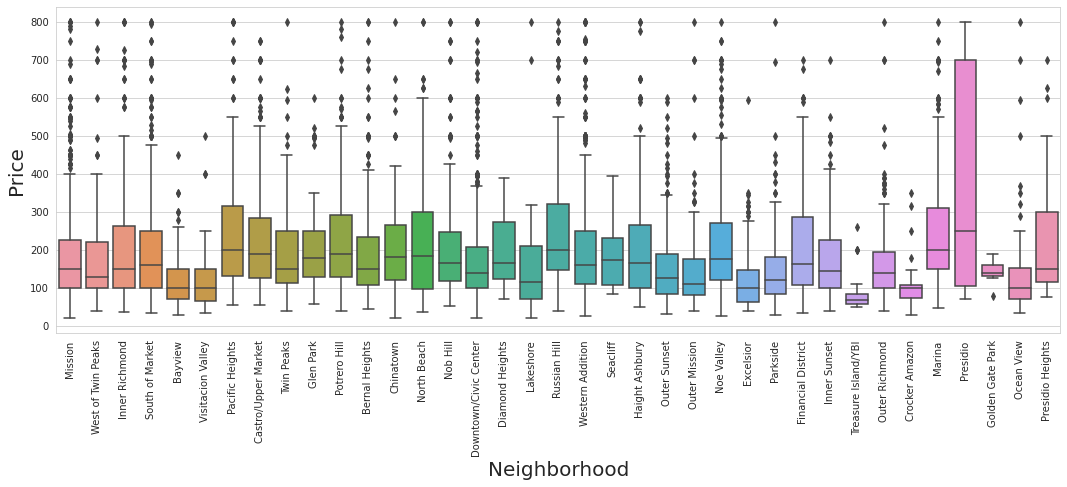

In [350]:
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["Neighbourhood"], y = df["Price"])#, palette="Blues");
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=90);
plt.xlabel("Neighborhood", size=20)
plt.ylabel("Price", size=20)
plt.show();

In [351]:
# Pricec distribution across Neighborhood



fig = px.box(df, x="Neighbourhood", y="Price", title = 'Price Distribution Across Neighborhood')
fig.show()

# py.plot(fig, filename = 'nbrhood-price', auto_open=True)

In [352]:
# Number of people can be accommodated and price

fig = px.box(df, x="Accommodates", y="Price", title = 'Price Distributions over #Accommodated Guests')

fig.show()
# py.plot(fig, filename = 'accommodates-price', auto_open=True)

In [353]:
# Same graph with scatter plot

fig = px.scatter(df, x="Accommodates", y="Price", trendline='ols', width=1000, height=400)
fig.show()

In [354]:
# Accommodates distribution

fig = px.histogram(df, x="Accommodates",  title="#Beds in 'Accommodates' Distribution" ,  nbins=40, color='Beds', width=1000, height=500) #.update_xaxes(categoryorder="total descending")

fig.update_layout(legend=dict( yanchor="top",  y=.95,  xanchor="right", x=.95 ))


# plt.xlabel("Neighborhood", size=20);
# plt.ylabel("Count", size=20);
fig.show();

# fig.write_html("histogram3.html")
# py.plot(fig, filename = 'accomodates-bedrm-count', auto_open=True)

###!!The above figure shows that the Accommodates-Price trend line is not linear when #Accommodates is above 10

In [355]:
# Property-Type and Price

fig = px.box(df, x="Property_Type", y="Price", title = 'Price Distribution over Property types', width=1000, height=400)

fig.show()
# py.plot(fig, filename = 'price-property_type', auto_open=True)

In [356]:
# Number Bedrooms and price

fig = px.box(df, x="Bedrooms", title = 'Price distributions for each #Bedrooms', y="Price",width=1000, height=400)

fig.show()
# py.plot(fig, filename = 'bedroom-price', auto_open=True)

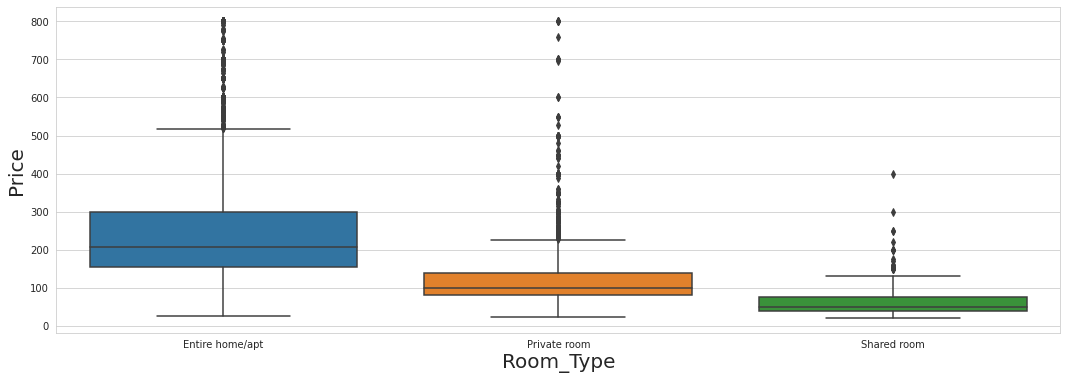

In [357]:
# Room type and Price


plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["Room_Type"], y = df["Price"])#, palette="Blues");
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=0);
plt.xlabel("Room_Type", size=20)
plt.ylabel("Price", size=20)
plt.show()


##Airbnb San Francisco Mapping

In [358]:
# Mapping based on #Bedrooms

fig = px.scatter_mapbox(df,  title = "San Francisco Map", lat="Latitude", lon="Longitude", color=df['Neighbourhood'],  width=1000, height=700, zoom=10)
fig.update_layout(mapbox_style="open-street-map")
fig.show()


fig.write_html("map3.html")
# py.plot(fig, filename = 'map3', auto_open=True)

In [359]:
# Define X & y

X_train = df[features].drop(columns='Price')
y_train = df['Price']

In [360]:
# Split into train & test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [361]:
X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((6719, 52), (6719,), (1680, 52), (1680,))

#1 - Using Linear Regression

###1-1 Baseline

In [362]:
y_train.describe()

count    6719.000000
mean      199.018455
std       138.409232
min        20.000000
25%       100.000000
50%       155.000000
75%       250.000000
max       800.000000
Name: Price, dtype: float64

In [363]:
y_test.describe()

count    1680.000000
mean      195.310119
std       139.659395
min        22.000000
25%        99.000000
50%       150.000000
75%       250.000000
max       800.000000
Name: Price, dtype: float64

###The baseline shows :  
average price  = $199,  
with st_deviation of 138.  
This shows that the price distribution has a big spred


In [364]:
!pip install category_encoders
!pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.2.2)


In [365]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Must put Standard Scaler . later on I need to take out some features based on coef_

linreg = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    # StandardScaler(), 
    LinearRegression()
)

In [366]:
# Fit the model
linreg.fit(X_train, y_train)
y_pred_lr = linreg.predict(X_test)

###Coefficients, intercept & metrics

In [367]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse_lr = np.round(mean_squared_error(y_test, y_pred_lr),3)
rmse_lr = np.round(np.sqrt(mse_lr),3)
mae_lr = np.round(mean_absolute_error(y_test, y_pred_lr),3)
r2_lr = np.round(r2_score(y_test, y_pred_lr),3)

print('MAE    :', mae_lr)
print('MSE    :', mse_lr)
print('RMSE   :', rmse_lr)
print('R^2 =  :', r2_lr)

MAE    : 66.058
MSE    : 10012.447
RMSE   : 100.062
R^2 =  : 0.486


In [368]:
# Test
# mean_absolute_error(y_test, y_pred_lr) == mean_absolute_error(y_test, linreg.predict(X_test))

In [369]:
lrcoef = linreg.named_steps['linearregression'].coef_
lrcoef

array([-3.97354920e-02, -3.97354852e-02,  2.45681951e+01,  1.69563851e+01,
        3.52430361e+01, -8.02001650e+00, -2.73454575e-02,  2.77782191e-01,
        4.32257966e-01, -8.14800588e-02, -4.63911376e-01,  1.48911655e-08,
        7.74464051e-01, -3.60152181e-01,  1.94015487e-01,  2.21498300e-02,
       -2.31575575e-01,  1.08515443e+00,  2.06191480e-01,  1.24882430e+01,
        5.82256369e-01, -4.29191387e+00,  7.88575061e+00, -1.30311386e+01,
       -8.36574535e-01, -2.11704096e+00, -3.71602641e-04,  1.52779759e-05,
        6.27187236e-06, -4.00910669e+00,  1.91166808e+01, -3.11660599e+01,
       -1.05425838e+01,  2.94551298e-01, -2.86391134e+00,  3.68548897e+00,
        2.32783971e+01, -1.08063787e+01,  1.78660501e+01, -1.24344979e-14,
        1.23701639e+01, -1.32727525e+01, -9.52446969e-01, -5.32252438e-01,
       -9.18351804e+00, -5.56762476e+01,  1.03573561e+00,  3.88964748e+01,
       -9.01037801e+00, -2.50160430e-01, -7.64929594e-01, -3.54214298e-01])

In [370]:
pd.Series(lrcoef, X_train.columns).sort_values(ascending=False).head(20)

Room_Type                    38.896475
Bedrooms                     35.243036
Accommodates                 24.568195
Gym                          23.278397
TV                           19.116681
AirCon                       17.866050
Bathrooms                    16.956385
Review_Scores_Cleanliness    12.488243
Pool                         12.370164
Review_Scores_Location        7.885751
Washer                        3.685489
Review_Scores_Rating          1.085154
Property_Type                 1.035736
Availability_30               0.774464
Review_Scores_Checkin         0.582256
Guests_Included               0.432258
Kitchen                       0.294551
Cleaning_Fee                  0.277782
Review_Scores_Accuracy        0.206191
Availability_90               0.194015
dtype: float64

In [371]:
# Charting the top-20 coefficients:

df_linreg = pd.Series(lrcoef, X_train.columns, name = 'coef').sort_values(ascending=False).head(20).to_frame()
df_linreg["features"] = df_linreg.index
df_linreg = df_linreg.reset_index().drop(columns = 'index')
df_linreg

,coef,features
0,38.896475,Room_Type
1,35.243036,Bedrooms
2,24.568195,Accommodates
3,23.278397,Gym
4,19.116681,TV
5,17.866050,AirCon
6,16.956385,Bathrooms
7,12.488243,Review_Scores_Cleanliness
8,12.370164,Pool
9,7.885751,Review_Scores_Location


In [372]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            y = df_linreg['coef'],
            x = df_linreg['features'],
            orientation='v')
            )

# fig.update_layout(xaxis={'categoryorder':'category ascending'},  title = 'Linear Regression Coefficients')
fig.update_layout(xaxis={'categoryorder':'max descending'},  title = 'Top-20 Linear Regression Coefficients', width=1000, height=400)


fig.show()

# py.plot(fig, filename = 'linreg_coef', auto_open=True)

In [373]:
pd.Series(lrcoef, X_train.columns).sort_values(ascending=False).head()

Room_Type       38.896475
Bedrooms        35.243036
Accommodates    24.568195
Gym             23.278397
TV              19.116681
dtype: float64

In [374]:
linreg.named_steps['linearregression'].intercept_

# linreg.named_steps['linearregression']

6.2468184296245965

#2 - Using RandomForestRegressor

In [375]:
from sklearn.ensemble import RandomForestRegressor

rfr1 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=5, max_features=10, random_state=42)
)

In [376]:
rfr1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Host_Response_Time', 'Neighbourhood',
                                      'Zipcode', 'Market', 'Smart_Location',
                                      'Property_Type', 'Room_Type', 'Bed_Type',
                                      'Calendar_Updated', 'Cancellation_Policy',
                                      'Features'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Host_Response_Time',
                                          'data_type': dt...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features=10, max_leaf_nodes=None,
                                       max_samples=None,
                                   

In [377]:
y_pred_rfr1 = rfr1.predict(X_test)

In [378]:
from sklearn.metrics import mean_absolute_error


In [379]:
mse_rfr1 = np.round(mean_squared_error(y_test, y_pred_rfr1),3)
rmse_rfr1 = np.round(np.sqrt(mse_rfr1),3)
mae_rfr1 = np.round(mean_absolute_error(y_test, y_pred_rfr1),3)
r2_rfr1 = np.round(r2_score(y_test, y_pred_rfr1),3)

print('MAE   :', mae_rfr1)
print('MSE   :', mse_rfr1)
print('RMSE  :', rmse_rfr1)
print('R^2 = :', r2_rfr1)

MAE   : 62.947
MSE   : 9707.721
RMSE  : 98.528
R^2 = : 0.502


In [380]:
rfr_important = rfr1.named_steps['randomforestregressor'].feature_importances_  # feature_importances_ is called attributes

rfr_important

array([8.87503047e-03, 7.92470947e-03, 9.19405787e-02, 3.57943024e-02,
       2.19898357e-01, 2.95148136e-02, 7.95013162e-03, 8.60381108e-02,
       1.46815964e-02, 1.12185121e-02, 2.08191302e-02, 1.68664160e-02,
       9.43999431e-03, 1.56596041e-02, 1.65294731e-02, 2.30369155e-02,
       2.34791924e-02, 1.69812082e-02, 3.59473489e-03, 7.46480739e-03,
       2.19784369e-03, 2.39805945e-03, 7.92771554e-03, 5.08396495e-03,
       7.82846253e-03, 3.22106023e-02, 2.00656168e-02, 2.63178965e-02,
       2.25243303e-02, 3.21247793e-03, 4.65579957e-03, 2.65557556e-03,
       2.09818786e-03, 1.73800111e-03, 2.98222438e-03, 6.55718793e-03,
       2.20473991e-03, 5.43436786e-03, 4.66740812e-03, 0.00000000e+00,
       2.41131950e-03, 1.83850620e-02, 2.10416465e-02, 2.86181535e-02,
       1.94331968e-04, 1.05849253e-07, 1.54221951e-02, 2.97057837e-02,
       2.52628568e-03, 2.46572346e-02, 8.78441039e-03, 1.77853908e-02])

In [381]:
fi_rfr = pd.Series(rfr_important, X_train.columns).sort_values(ascending=False).head(20)

fi_rfr

Bedrooms                0.219898
Accommodates            0.091941
Cleaning_Fee            0.086038
Bathrooms               0.035794
Reviews_per_Month       0.032211
Room_Type               0.029706
Beds                    0.029515
Zipcode                 0.028618
Home_Value              0.026318
Calendar_Updated        0.024657
Number_of_Reviews       0.023479
Availability_365        0.023037
Median_Income           0.022524
Neighbourhood           0.021042
Minimum_Nights          0.020819
Population              0.020066
Host_Response_Time      0.018385
Features                0.017785
Review_Scores_Rating    0.016981
Maximum_Nights          0.016866
dtype: float64

In [382]:
# !pip install -U plotly

# Convert Series into Dataframes

dfi = pd.Series(fi_rfr, name='importance').to_frame()
dfi['features'] = dfi.index

# dfi

In [383]:
dfi = dfi.reset_index().drop(columns='index')
dfi

,importance,features
0,0.219898,Bedrooms
1,0.091941,Accommodates
2,0.086038,Cleaning_Fee
3,0.035794,Bathrooms
4,0.032211,Reviews_per_Month
5,0.029706,Room_Type
6,0.029515,Beds
7,0.028618,Zipcode
8,0.026318,Home_Value
9,0.024657,Calendar_Updated


In [384]:
import plotly.graph_objects as go

colors = ['grey',] * 40
colors[8] = 'red'
colors[12] = 'red'
colors[15] = 'red'


fig = go.Figure(go.Bar(
            y=dfi['importance'],
            x=dfi['features'],
            orientation='v',
            marker_color=colors)
            )

fig.update_layout(xaxis={'categoryorder':'max descending'},  title = 'Top-20 Features that Predict the Price', width=1000, height=400)
fig.show()

# py.plot(fig, filename = 'feature_imp2', auto_open=True)

In [385]:
# rfr1.named_steps['randomforestregressor'].estimators_

In [386]:
# rfr1.named_steps['randomforestregressor'].base_estimator_

In [387]:
# Visualisation y_pred & y_test

drfr = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_rfr1})
drfr

,y_test,y_pred
33,125.0,127.6
5456,290.0,292.6
5073,425.0,253.0
3408,280.0,352.0
4912,100.0,116.0
...,...,...
338,90.0,150.0
2488,699.0,499.8
6316,100.0,100.4
6115,120.0,150.2


Let's see the price error distribution.  
We see that the most error is on the lowest price.

In [388]:
# Error calculation:

drfr['error'] = abs(drfr['y_test'] - drfr['y_pred'])
# drfr['error']

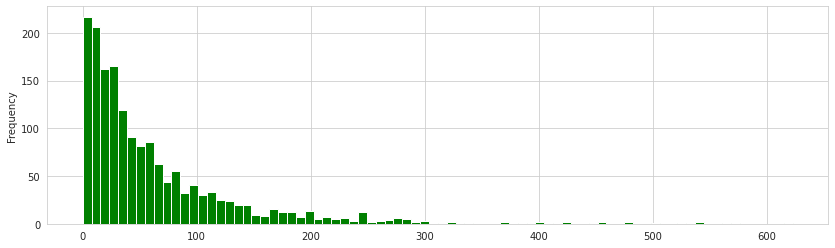

In [389]:
# Error distribution plot
drfr['error'].plot(kind='hist', color='green', bins=80, figsize=(14,4));

In [390]:
drfr[drfr['error']<10]

,y_test,y_pred,error
33,125.0,127.6,2.6
5456,290.0,292.6,2.6
5615,150.0,141.0,9.0
5082,100.0,101.2,1.2
791,180.0,180.0,0.0
...,...,...,...
5446,130.0,130.8,0.8
1675,100.0,95.2,4.8
5866,90.0,99.6,9.6
6316,100.0,100.4,0.4


#RandomForest Regressor to find the best parameters:

In [391]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from category_encoders import OneHotEncoder, OrdinalEncoder

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    # 'targetencoder__min_samples_leaf': randint(1, 1000),     # sometimes this doesnt work - weird!!
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [4, 7, 10, 15], 
    'randomforestregressor__max_features': uniform(0, 1), 
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)


In [392]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [393]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ordinalencoder', 'simpleimputer', 'randomforestregressor', 'ordinalencoder__cols', 'ordinalencoder__drop_invariant', 'ordinalencoder__handle_missing', 'ordinalencoder__handle_unknown', 'ordinalencoder__mapping', 'ordinalencoder__return_df', 'ordinalencoder__verbose', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_e

In [394]:
y_pred_rfr2 = search.predict(X_test)

In [395]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.32521106977895387, 'randomforestregressor__n_estimators': 439, 'simpleimputer__strategy': 'median'}
Cross-validation MAE 56.52657617928791


In [396]:
# Best Accuracy for n_iter = 

mse_rfr2 = np.round(mean_squared_error(y_test, y_pred_rfr2),3)
rmse_rfr2 = np.round(np.sqrt(mse_rfr2),3)
mae_rfr2 = np.round(mean_absolute_error(y_test, y_pred_rfr2),3)
r2_rfr2 = np.round(r2_score(y_test, y_pred_rfr2),3)

print('MAE   :', mae_rfr2)
print('MSE   :', mse_rfr2)
print('RMSE  :', rmse_rfr2)
print('R^2 = :', r2_rfr2)

MAE   : 54.607
MSE   : 7443.435
RMSE  : 86.275
R^2 = : 0.618


#Try again RandomForestRegressor with another method, increase n_iter

In [397]:
from scipy.stats import randint, uniform

pipeline3 = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [3, 5, 7, 10], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

search3 = RandomizedSearchCV(
    pipeline3, 
    param_distributions=param_distributions, 
    n_iter=40, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search3.fit(X_train, y_train);

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.7min finished


In [398]:
y_pred_rfr3 = search3.predict(X_test)

In [399]:
print('Best hyperparameters', search3.best_params_)
print('Cross-validation MAE', -search3.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.946826036621927, 'randomforestregressor__n_estimators': 214, 'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 12}
Cross-validation MAE 56.55428482364105


In [400]:
mse_rfr3 = np.round(mean_squared_error(y_test, y_pred_rfr3),3)
rmse_rfr3 = np.round(np.sqrt(mse_rfr3),3)
mae_rfr3 = np.round(mean_absolute_error(y_test, y_pred_rfr3),3)
r2_rfr3 = np.round(r2_score(y_test, y_pred_rfr3),3)

print('MAE   :', mae_rfr3)
print('MSE   :', mse_rfr3)
print('RMSE  :', rmse_rfr3)
print('R^2 = :', r2_rfr3)

MAE   : 55.078
MSE   : 7373.706
RMSE  : 85.87
R^2 = : 0.622


In [401]:
# pd.DataFrame(search2.cv_results_).sort_values(by='rank_test_score').T

In [402]:
pipeline3 = search3.best_estimator_
pipeline3

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['Host_Response_Time', 'Neighbourhood',
                                     'Zipcode', 'Market', 'Smart_Location',
                                     'Property_Type', 'Room_Type', 'Bed_Type',
                                     'Calendar_Updated', 'Cancellation_Policy',
                                     'Features'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=12,
                               return_df=True, smoothing=1.0, verb...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=10,
                                       max_features=0.946826036621927,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
     

In [403]:
# rfr1.named_steps['randomforestregressor'].estimators_

#3a - Using XGBRegressor with pipeline

In [404]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot
from xgboost import plot_importance

In [405]:
XGBRegressor?

In [406]:
xgbreg1 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=10, random_state=42, n_jobs=2, max_depth=4,  learning_rate=0.1)
)

xgbreg1.fit(X_train, y_train)

[00:55:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Host_Response_Time', 'Neighbourhood',
                                      'Zipcode', 'Market', 'Smart_Location',
                                      'Property_Type', 'Room_Type', 'Bed_Type',
                                      'Calendar_Updated', 'Cancellation_Policy',
                                      'Features'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Host_Response_Time',
                                          'data_type': dt...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=4, min_child_weight=1,
                           

In [407]:
# Make predictions on the test set
from sklearn.metrics import r2_score

y_pred_xg1 = xgbreg1.predict(X_test)

In [408]:
mse_xg1 = np.round(mean_squared_error(y_test, y_pred_xg1),3)
rmse_xg1 = np.round(np.sqrt(mse_xg1),3)
mae_xg1 = np.round(mean_absolute_error(y_test, y_pred_xg1),3)
r2_xg1 = np.round(r2_score(y_test, y_pred_xg1),3)

print('MAE   :', mae_xg1)
print('MSE   :', mse_xg1)
print('RMSE  :', rmse_xg1)
print('R^2 = :', r2_xg1)

MAE   : 79.046
MSE   : 15843.687
RMSE  : 125.872
R^2 = : 0.187


# 3b. Using XGBoostRegressor with Data Matrix  (MAE & RMSE only)
* https://www.datacamp.com/community/tutorials/xgboost-in-python  
* Only for MAE & *RMSE*

In [409]:
# This X_train_encoded value will be used for feature importance

encoder = ce.OrdinalEncoder()
imputer = SimpleImputer()
scaler = StandardScaler()

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)


In [410]:
X_train_encoded
# X_train_encoded.isnull().sum()
# X_train_imputed

,Host_Listings_Count,Host_Total_Listings_Count,Accommodates,Bathrooms,Bedrooms,Beds,Security_Deposit,Cleaning_Fee,Guests_Included,Extra_People,Minimum_Nights,Maximum_Nights,Availability_30,Availability_60,Availability_90,Availability_365,Number_of_Reviews,Review_Scores_Rating,Review_Scores_Accuracy,Review_Scores_Cleanliness,Review_Scores_Checkin,Review_Scores_Communication,Review_Scores_Location,Review_Scores_Value,Calculated_host_listings_count,Reviews_per_Month,Population,Home_Value,Median_Income,FreeParking,TV,Internet,Breakfast,Kitchen,Heating,Washer,Gym,Essentials,AirCon,NonSmoking,Pool,Host_Response_Time,Neighbourhood,Zipcode,Market,Smart_Location,Property_Type,Room_Type,Bed_Type,Calendar_Updated,Cancellation_Policy,Features
7686,1.0,1.0,2,1.0,1.0,1.0,300.0,49.0,1,20,3,1125,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.00,21884,1067308,127427,0,1,1,0,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
2570,1.0,1.0,1,1.5,1.0,1.0,500.0,0.0,1,0,1,1125,15,37,37,212,39,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.70,22358,1454491,129602,0,1,1,0,1,1,1,0,1,0,0,0,2,2,2,1,1,1,1,1,2,2,2
923,1.0,1.0,2,1.0,1.0,1.0,0.0,40.0,1,30,3,1125,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.14,10136,557736,35896,0,1,1,0,1,1,1,0,1,0,0,0,1,3,3,1,1,1,1,1,3,2,1
4581,4.0,4.0,5,2.0,3.0,3.0,700.0,100.0,1,0,4,1125,0,0,0,91,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,4,0.30,28638,866685,109995,1,0,1,0,1,1,1,0,1,0,0,0,3,4,4,1,1,1,2,1,4,2,3
8657,20.0,20.0,4,1.0,1.0,1.0,0.0,0.0,1,45,1,14,30,56,56,269,93,91.0,9.0,9.0,10.0,10.0,9.0,9.0,16,1.42,6974,654150,101601,0,1,1,0,1,1,1,0,0,0,0,0,4,5,5,1,1,2,3,1,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5925,1.0,1.0,2,1.0,1.0,1.0,100.0,60.0,1,0,5,11,2,9,39,177,14,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,1.10,56009,867014,97270,0,0,1,0,1,1,0,0,0,0,0,0,4,6,4,1,1,1,2,1,25,3,1
5362,2.0,2.0,1,1.0,1.0,1.0,0.0,0.0,1,0,1,14,29,59,89,89,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,2,0.42,21074,1219727,133927,0,0,1,0,1,1,1,0,1,0,0,0,2,18,16,2,1,5,1,1,20,2,4
5571,1.0,1.0,2,1.0,1.0,1.0,500.0,75.0,2,10,2,1125,7,17,26,242,31,88.0,10.0,9.0,10.0,10.0,9.0,9.0,1,2.84,36055,1024713,88321,0,1,1,0,1,1,1,0,1,0,0,0,2,19,17,1,1,1,2,1,4,1,6
890,1.0,1.0,6,1.0,2.0,2.0,500.0,150.0,1,0,3,7,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.00,27661,854611,92322,1,1,1,0,1,0,0,0,0,0,0,0,1,26,15,1,1,3,2,1,38,1,1


In [411]:
# convert the dataset into an optimized data structure called Dmatrix

data_dmatrix = xgb.DMatrix(data = X_train_encoded,label=y_train) ## this is called d_train, not d_test

dtest = xgb.DMatrix(X_test_encoded, label=y_test)

In [412]:
X_test_encoded.shape

(1680, 52)

In [413]:
X_train_encoded.shape, y_train.shape

((6719, 52), (6719,))

In [414]:
# K-fold X-validation. 


k=5
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10}

# This cv_results contains train and test RMSE metrics for each boosting round

cv_results_mae = xgb.cv(dtrain=data_dmatrix, params=params, nfold=k,
                    num_boost_round=50,early_stopping_rounds=10,metrics="mae", as_pandas=True, seed=123)

cv_results_rmse = xgb.cv(dtrain=data_dmatrix, params=params, nfold=k,
                    num_boost_round=50,early_stopping_rounds=10,metrics='rmse'  , as_pandas=True, seed=123)      

# cv_results_rmse = xgb.cv(dtrain=data_dmatrix, params=params, nfold=k,
#                     num_boost_round=50,early_stopping_rounds=10,metrics='error'  , as_pandas=True, seed=123)      


# We can also use - metric=list() -  meaning:  use all possible metrics
cv_results_list = xgb.cv(dtrain=data_dmatrix, params=params, nfold=k,
                    num_boost_round=50,early_stopping_rounds=10,metrics=list()  , as_pandas=True, seed=123)      



In [415]:
# cv_results_mae.tail()
# cv_results_rmse.tail()
cv_results_list.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
45,36.275708,0.306222,86.004164,1.918083
46,35.699425,0.200440,86.002868,1.892660
47,35.136348,0.170043,85.949930,1.855472
48,34.627062,0.181622,85.924193,1.856708
49,34.218115,0.145863,85.901079,1.854390


In [416]:
# Final RMSE: get the lowest train-RMSE value

print(cv_results_mae.tail(1))
print()
print(cv_results_rmse.tail(1))

    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
49       21.212617       0.119448      54.077064      1.066427

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49        34.218115        0.145863       85.901079        1.85439


#3c. Using XGBoostRegressor without pipeline

In [417]:
xg2 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 20, alpha = 10, n_estimators = 70)

In [418]:
xg2.fit(X_train_encoded,y_train)

[00:55:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=70,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [419]:
y_pred_xg2 = xg2.predict(X_test_encoded)

In [420]:
mse_xg2 = np.round(mean_squared_error(y_test, y_pred_xg2),3)
rmse_xg2 = np.round(np.sqrt(mse_xg2),3)
mae_xg2 = np.round(mean_absolute_error(y_test, y_pred_xg2),3)
r2_xg2 =  np.round(r2_score(y_test, y_pred_xg2),3)

print('MAE   :', mae_xg2)
print('MSE   :', mse_xg2)
print('RMSE  :', rmse_xg2)
print('R^2 = :', r2_xg2)

MAE   : 53.851
MSE   : 7500.802
RMSE  : 86.607
R^2 = : 0.615


##Visualize Boosting Trees and Feature Importance with XGB

In [421]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [422]:
# Plot the 1st tree

xgb.plot_tree(xg_reg,num_trees=1)
# plt.rcParams['figure.figsize'] = [70, 70]
plt.figure(figsize=(20,20));
plt.show()


<Figure size 1440x1440 with 0 Axes>

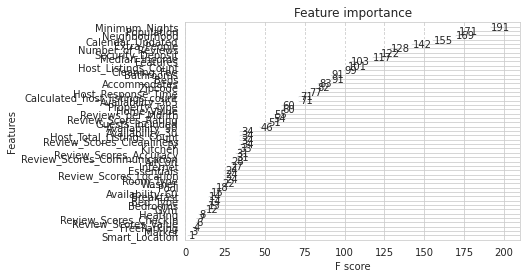

In [423]:
# XGBoost has a plot_importance() function . easy.

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 10]
plt.show();

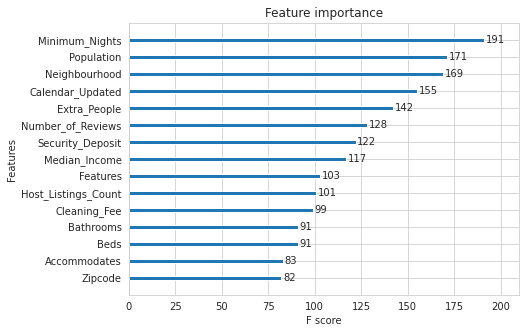

In [424]:
# XGBoost has a plot_importance() function . easy.

ax3 = xgb.plot_importance(xg_reg, max_num_features=15)
fig = ax3.figure
fig.set_size_inches(7,5);


#Trying to get XGB Hyper Parameter  
### https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/


In [425]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder


# encoder = LabelEncoder()
encoder = OrdinalEncoder()

X_train_xg4 = encoder.fit_transform(X_train)
X_test_xg4 = encoder.fit_transform(X_test)
# y_test_xg4 = encoder.fit_transform(y_test)

xgb4 = XGBRegressor()


param_distributions = {
        'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
        'min_child_weight': np.arange(0.0001, 0.5, 0.001),
        'gamma': np.arange(0.0,40.0,0.005),
        'learning_rate': np.arange(0.0005,0.3,0.0005),
        'subsample': np.arange(0.01,1.0,0.01),
        'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
        'colsample_bytree': np.arange(0.1,1.0,0.01),
}

search4 = RandomizedSearchCV(
    xgb4, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

In [426]:
xgb4.fit(X_train_xg4, y_train) ## without optim

[00:55:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [427]:
search4.fit(X_train_xg4, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

[00:57:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72,

In [428]:
y_pred_xg4 = search4.predict(X_test_xg4)

In [429]:
optim_result = search4.fit(X_train_xg4, y_train)

# summarize results
print("Best: %f using %s" % (optim_result.best_score_, optim_result.best_params_))
means = optim_result.cv_results_[ 'mean_test_score' ]
stds = optim_result.cv_results_[ 'std_test_score' ]
params = optim_result.cv_results_[ 'params' ]


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

[00:59:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -53.431549 using {'subsample': 0.79, 'min_child_weight': 0.3261, 'max_depth': 5, 'learning_rate': 0.10450000000000001, 'gamma': 0.34, 'colsample_bytree': 0.5999999999999998, 'colsample_bylevel': 1.0}


In [430]:
# params

In [431]:
means

array([ -60.23077079,  -55.52823012,  -58.48465317,  -62.06959815,
        -57.16469583,  -54.76853852,  -57.63415502,  -59.56916289,
        -59.55474454,  -53.53589593,  -58.83436655,  -57.29337585,
        -64.77781338,  -57.46644663,  -55.70693836,  -54.86335563,
        -86.32282603,  -67.19997072,  -60.05296688,  -57.97261542,
        -53.43154856,  -60.69561644,  -69.08098047,  -63.09236841,
        -58.63733202,  -58.48708605,  -63.4657029 ,  -63.40961359,
        -56.98725879,  -59.2767732 ,  -56.44075818,  -59.48805562,
       -106.34348426,  -79.66958315,  -73.60873019,  -58.55208766,
        -62.49506912,  -59.05344527,  -66.33737311,  -60.50178455,
        -61.32438165,  -59.49706089,  -59.36165927,  -57.83887539,
        -70.12465701,  -61.01577069,  -54.32255738,  -66.89715285,
        -59.29471421,  -54.10686011])

In [432]:
# Merics

mse_xg4 = np.round(mean_squared_error(y_test, y_pred_xg4),3)
rmse_xg4 = np.round(np.sqrt(mse_xg4),3)
mae_xg4 = np.round(mean_absolute_error(y_test, y_pred_xg4),3)
r2_xg4 =  np.round(r2_score(y_test, y_pred_xg4),3)

print('MAE   :', mae_xg4)
print('MSE   :', mse_xg4)
print('RMSE  :', rmse_xg4)
print('R^2 = :', r2_xg4)

MAE   : 53.557
MSE   : 7178.862
RMSE  : 84.728
R^2 = : 0.632


In [433]:
# Compare with the TRAINING metric

print('Training MAE:', mean_absolute_error(y_train, search4.predict(X_train_xg4)))

Training MAE: 42.00854952645135


In [434]:
# XGB feature_importances_
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/


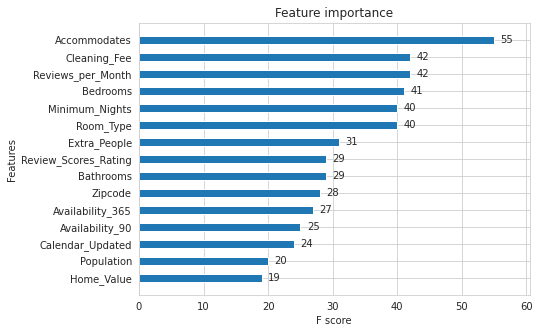

In [435]:
# PLOTTING, can be done in many ways:

# plot_importance(xgb4, max_num_features=15, height=0.5)#, xlim=(0,10), ylim=(0,10))
# # fig.set_size_inches(4,2);
# pyplot.show()

# or

ax4 = plot_importance(xgb4, max_num_features=15, height=0.5)#, 
fig  = ax4.figure
fig.set_size_inches(7,5);

# or 

# ax4 = xgb.plot_importance(xgb4, max_num_features=15)
# fig = ax4.figure
# fig.set_size_inches(7,5);

In [436]:
# search4.feature_importances_

#Which model is the best?  
The best ML model in this dataset is: lowest MAE and biggest R2

In [437]:
# Create dataframe out of all metrics

Model = ['LinearRegression', 'RFRegression_1', 'RFRegression_2', 'RFRegression_3', 'XGB_1',  'XGB_2' , 'XGB_3']
MAE = [mae_lr, mae_rfr1, mae_rfr2, mae_rfr3, mae_xg1, mae_xg2, mae_xg4]
MSE = [mse_lr, mse_rfr1, mse_rfr2, mse_rfr3, mse_xg1, mse_xg2, mse_xg4]
RMSE = [rmse_lr, rmse_rfr1, rmse_rfr2, rmse_rfr3, rmse_xg1, rmse_xg2, rmse_xg4]
R2 = [r2_lr, r2_rfr1, r2_rfr2, r2_rfr3, r2_xg1, r2_xg2, r2_xg4]
Parameter = ['static', 'static', 'static', 'optimized', 'static', 'static', 'opimized' ]

cols = {'Model':Model, 'MAE':MAE ,  'MSE': MSE,  'RMSE': RMSE, 'R2': R2, 'Parameter': Parameter}

metric1 = pd.DataFrame(cols)
# metric1 = pd.DataFrame(cols, index = ['LinearRegression', 'RFRegression', 'RFRegression_best', 'XGB'])

metric1

,Model,MAE,MSE,RMSE,R2,Parameter
0,LinearRegression,66.058,10012.447,100.062,0.486,static
1,RFRegression_1,62.947,9707.721,98.528,0.502,static
2,RFRegression_2,54.607,7443.435,86.275,0.618,static
3,RFRegression_3,55.078,7373.706,85.870,0.622,optimized
4,XGB_1,79.046,15843.687,125.872,0.187,static
5,XGB_2,53.851,7500.802,86.607,0.615,static
6,XGB_3,53.557,7178.862,84.728,0.632,opimized


In [438]:
Best_model = metric1.tail(1)
Best_model

,Model,MAE,MSE,RMSE,R2,Parameter
6,XGB_3,53.557,7178.862,84.728,0.632,opimized


In [468]:
metric1[metric1['MAE']<53.7]

,Model,MAE,MSE,RMSE,R2,Parameter
6,XGB_3,53.557,7178.862,84.728,0.632,opimized


#PDP-Plot

In [439]:
plt.rcParams['figure.dpi'] = 72

In [440]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature_xgbr = 'Accommodates'

isolated = pdp_isolate(
    model=xgbreg1,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature_xgbr
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f66f7a03668>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f66f7a3b9e8>})

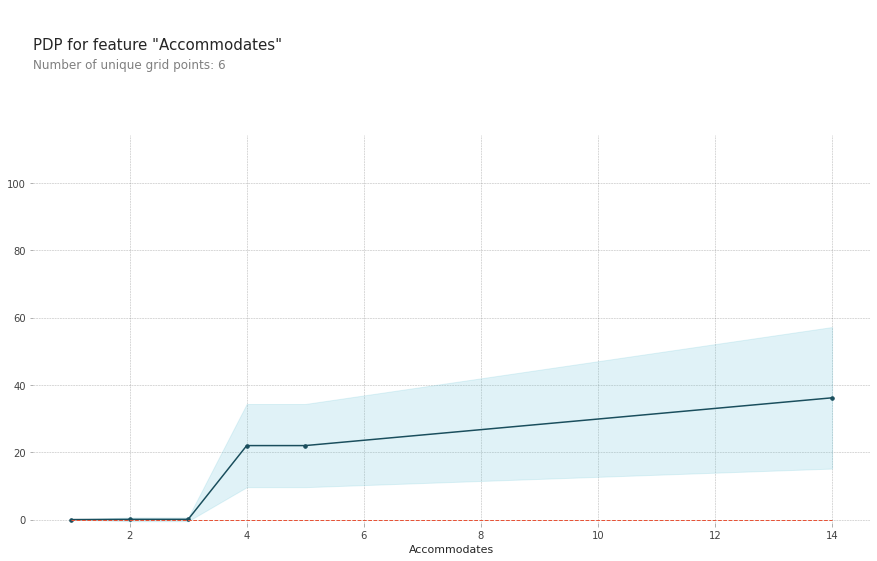

In [441]:
pdp_plot(isolated, feature_name=feature_xgbr)

##PDP-Plot with 2 features


In [442]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features2a = ['Bedrooms', 'Accommodates']

interaction = pdp_interact(
    model=xgbreg1,
    dataset=X_test,
    model_features=X_test.columns,
    features=features2a
)

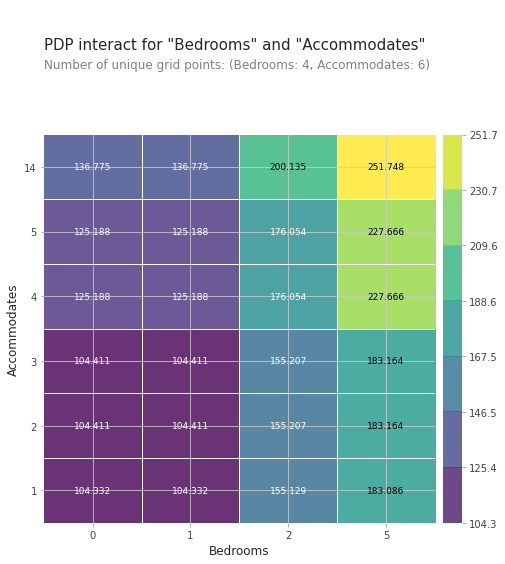

In [443]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features2a);

#Shapley Value

In [444]:
# Let's limit the features into:

feature_sh = ['Accommodates',  'Bathrooms', 'Bedrooms', 'Beds', 'Cleaning_Fee', 'Reviews_per_Month'] 

In [445]:
# Define X & y

X_train = df[feature_sh]
y_train = df['Price']

In [446]:
# Split into train & test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((6719, 6), (6719,), (1680, 6), (1680,))

In [447]:
# I want to compare between xgbreg1 & xgbreg2.  Pipeline and non-pipeline

xgbreg1 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=2, max_depth=4,  learning_rate=0.1)
)


xgbreg1.fit(X_train, y_train)

[00:59:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster=...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=4, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=2,
                              nthread=None, objective=

In [448]:
# encoder = ce.OrdinalEncoder()
# X_train_encoded = encoder.fit_transform(X_train)
# X_test_encoded = encoder.transform(X_test)

xgbreg2 = XGBRegressor(n_estimators=100, 
                       random_state=42, 
                       n_jobs=2, 
                       max_depth=4,  
                       learning_rate=0.1)

xgbreg2.fit(X_train, y_train)

[00:59:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=2, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [449]:
X_train.isnull().sum()

Accommodates         0
Bathrooms            0
Bedrooms             0
Beds                 0
Cleaning_Fee         0
Reviews_per_Month    0
dtype: int64

In [450]:
# Show particular features 

row = X_test.iloc[[1]]
row

,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning_Fee,Reviews_per_Month
5456,6,1.0,2.0,3.0,90.0,3.0


In [451]:
# What was the actual rent for this rbnb?
y_test.iloc[[1]]

5456    290.0
Name: Price, dtype: float64

In [452]:
# What does the model predict for this airbnb?
xgbreg2.predict(row)

array([224.09393], dtype=float32)

In [453]:
import shap 

explainer = shap.TreeExplainer(xgbreg2)
shap_values = explainer.shap_values(row)

# load JS visualization code to notebook
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

###Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue 

##Using the predict function

In [454]:
def predict(Accommodates, Bathrooms, Bedrooms, Beds, Cleaning_Fee, Reviews_per_Month):

    # Make dataframe from the inputs
    dshap = pd.DataFrame(
        data=[[Accommodates, Bathrooms, Bedrooms, Beds, Cleaning_Fee, Reviews_per_Month]], 
        columns=['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Cleaning_Fee', 'Reviews_per_Month']
    )



    # Get the model's prediction
    pred = xgbreg2.predict(dshap)[0]

    # Calculate shap values
    explainer = shap.TreeExplainer(xgbreg2)
    shap_values = explainer.shap_values(dshap)

    # Get series with shap values, feature names, & feature values
    feature_names = dshap.columns
    feature_values = dshap.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # Print results
    result = f'${pred:,.0f} estimated rent for this SF_airbnb. \n\n'
    #result += f'Starting from baseline of ${explainer.expected_value:,.0f} \n'
    result += shaps.to_string()
    print(result)


    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=dshap
    )



In [455]:
# features: Accommodates, Bathrooms, Bedrooms, Beds, Cleaning_Fee, Reviews_per_Month
predict(6, 1, 2, 2, 30, 5)

$192 estimated rent for this SF_airbnb. 

(Accommodates, 6)         40.724091
(Bathrooms, 1)           -22.209236
(Bedrooms, 2)             46.629822
(Beds, 2)                  3.192894
(Cleaning_Fee, 30)       -29.486845
(Reviews_per_Month, 5)   -45.914082


In [456]:
# Accommodates, Bathrooms, Bedrooms, Beds, Cleaning_Fee, Reviews_per_Month
predict(5, 2, 1, 1, 0, 2)

$178 estimated rent for this SF_airbnb. 

(Accommodates, 5)         60.768673
(Bathrooms, 2)             2.687924
(Bedrooms, 1)            -31.716887
(Beds, 1)                  0.709454
(Cleaning_Fee, 0)        -17.022001
(Reviews_per_Month, 2)   -36.240234


In [457]:
# Accommodates, Bathrooms, Bedrooms, Beds, Cleaning_Fee, Reviews_per_Month
predict(3, 2, 2, 1, 50, 2)

$236 estimated rent for this SF_airbnb. 

(Accommodates, 3)         -5.183322
(Bathrooms, 2)             8.350978
(Bedrooms, 2)             57.374184
(Beds, 1)                 -0.156027
(Cleaning_Fee, 50)        -7.587793
(Reviews_per_Month, 2)   -15.582948


# Attachment

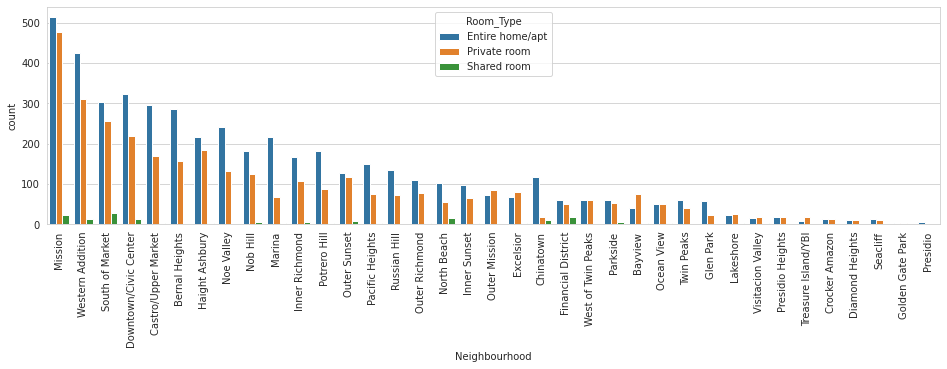

In [459]:
# Neighborhood & Room type

from seaborn import countplot

sns.set_style('whitegrid', {'axes.linewidth': 0.5}) # only: white, dark, whitegrid, darkgrid, ticks
plt.figure(figsize=(16,4))

chart = sns.countplot(x ='Neighbourhood',  data = df, hue='Room_Type', order= df['Neighbourhood'].value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);
